In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

1. Load and Explore Data (EDA)

Dataset loaded successfully.

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

--- First 5 Rows ---
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0 

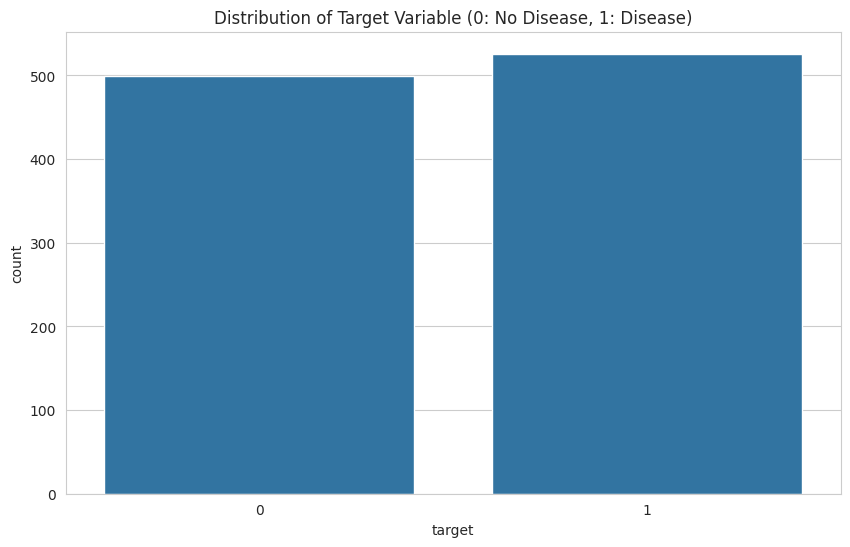

In [2]:
# Load the dataset
# Make sure the file path matches where Kaggle stores the input data
try:
    df = pd.read_csv('/content/heart.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: heart.csv not found. Please ensure the dataset is added correctly.")
    # As a fallback for local testing, you might load it like this:
    # df = pd.read_csv('heart.csv')
    # exit() # Or handle the error appropriately

# Display basic information
print("\n--- Dataset Info ---")
df.info()

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Descriptive Statistics ---")
print(df.describe())

print("\n--- Check for Missing Values ---")
print(df.isnull().sum())
# Good news: No missing values in this standard version of the dataset.

print("\n--- Target Variable Distribution ---")
target_counts = df['target'].value_counts()
print(target_counts)
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable (0: No Disease, 1: Disease)')
plt.show()

EDA Visualizations

Age Distribution:

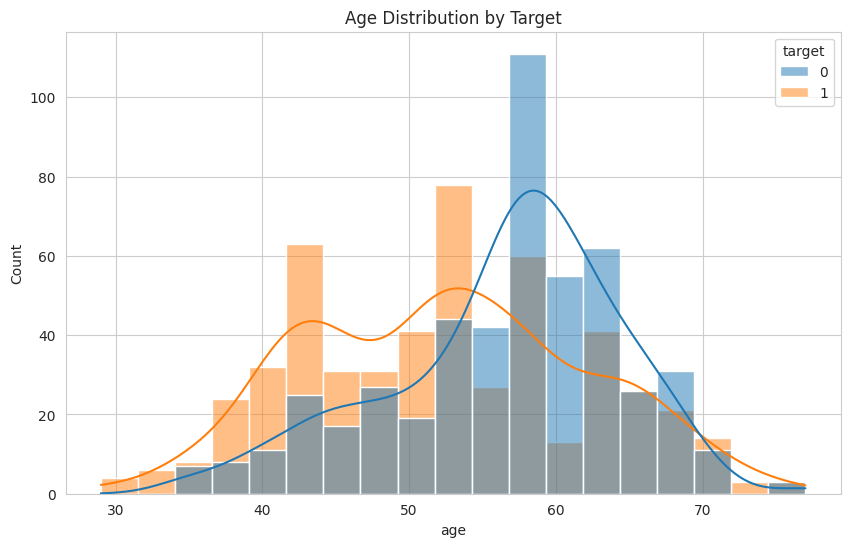

In [3]:
sns.histplot(data=df, x='age', hue='target', kde=True)
plt.title('Age Distribution by Target')
plt.show()

Sex Distribution: (0 = female, 1 = male)

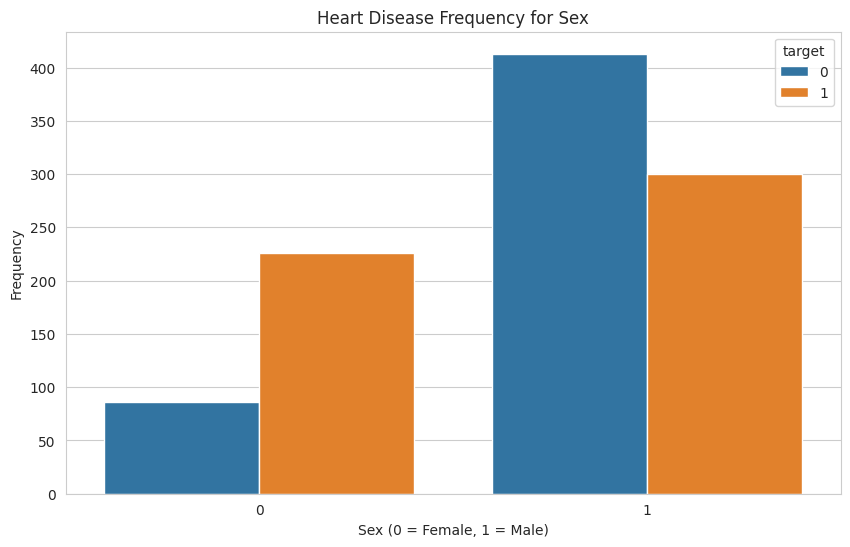

In [4]:
sns.countplot(data=df, x='sex', hue='target')
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Frequency')
plt.show()

Chest Pain Type (cp) Distribution:

0: Typical angina
1: Atypical angina
2: Non-anginal pain
3: Asymptomatic

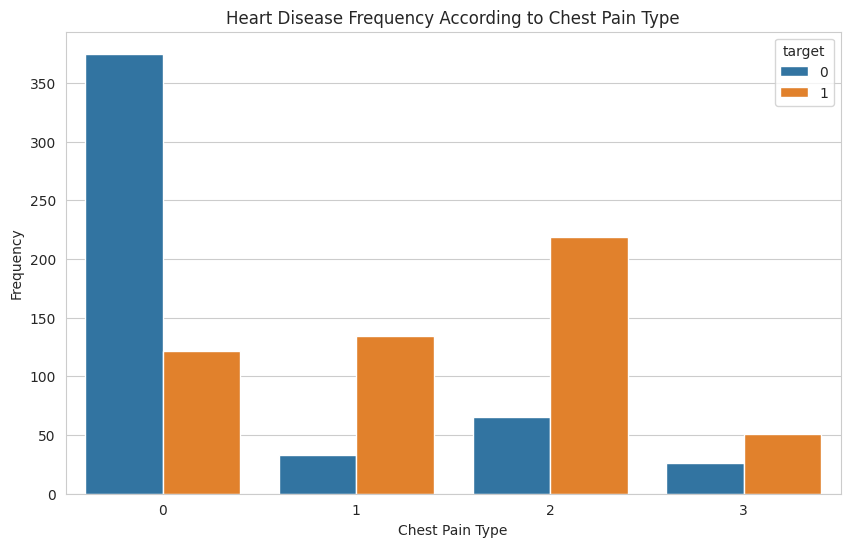

In [5]:
sns.countplot(data=df, x='cp', hue='target')
plt.title('Heart Disease Frequency According to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.ylabel('Frequency')
plt.show()

Correlation Heatmap:

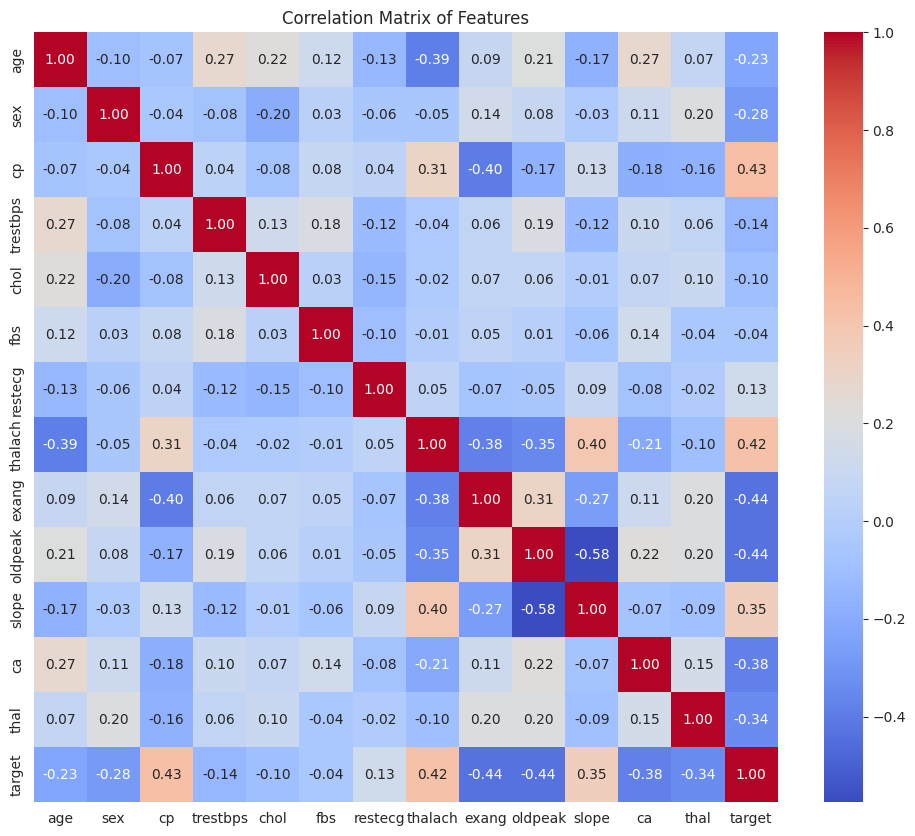

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

2. Data Preprocessing

*  Categorical features: sex, cp, fbs, restecg, exang, slope, ca, thal. Some are binary, others are nominal/ordinal. We'll use One-Hot Encoding for nominal features with more than 2 categories (cp, restecg, slope, thal, ca). Note: sex, fbs, exang are already 0/1.

* Numerical features: age, trestbps, chol, thalach, oldpeak. We'll scale these






In [7]:
# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Identify feature types
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal'] # Features to one-hot encode
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# Binary features ('sex', 'fbs', 'exang') don't strictly need one-hot encoding or scaling if kept as 0/1

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Create preprocessing pipelines for numerical and categorical features
# Numerical pipeline: Scale features
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline: One-hot encode features
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' is safer for unseen categories in test set
])

# Combine pipelines using ColumnTransformer
# Apply num_pipeline to numerical features
# Apply cat_pipeline to categorical features needing one-hot encoding
# Passthrough binary features ('sex', 'fbs', 'exang') or include them if preferred
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
        ('passthrough', 'passthrough', ['sex', 'fbs', 'exang']) # Keep binary features as they are
    ],
    remainder='drop' # Drop any columns not specified (shouldn't be any here)
)

# Apply the preprocessing pipeline to the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply the *fitted* preprocessing pipeline to the testing data
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation (useful for some models like Tree-based ones)
feature_names_out = preprocessor.get_feature_names_out()
print(f"\nProcessed feature names ({X_train_processed.shape[1]} features):\n{feature_names_out}")


print(f"\nProcessed Training set shape: {X_train_processed.shape}")
print(f"Processed Test set shape: {X_test_processed.shape}")

Training set shape: (820, 13)
Test set shape: (205, 13)

Processed feature names (27 features):
['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3' 'cat__restecg_0'
 'cat__restecg_1' 'cat__restecg_2' 'cat__slope_0' 'cat__slope_1'
 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2' 'cat__ca_3'
 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2' 'cat__thal_3'
 'passthrough__sex' 'passthrough__fbs' 'passthrough__exang']

Processed Training set shape: (820, 27)
Processed Test set shape: (205, 27)


3. Train and Evaluate Machine Learning Models


1.   Logistic Regression
2.   Random Forest Classifier
3.   Support Vector Machine (SVM)



--- Training Logistic Regression ---

--- Results for Logistic Regression ---
Training Accuracy: 0.8744
Test Accuracy: 0.8732
Test ROC AUC: 0.9435
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       100
           1       0.86      0.90      0.88       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205

Test Confusion Matrix:
 [[84 16]
 [10 95]]


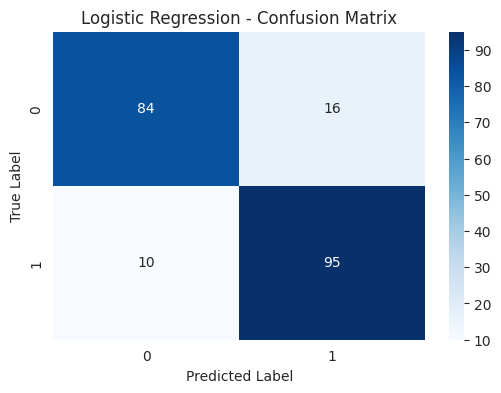

------------------------------
--- Training Random Forest ---

--- Results for Random Forest ---
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Test ROC AUC: 1.0000
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Test Confusion Matrix:
 [[100   0]
 [  0 105]]


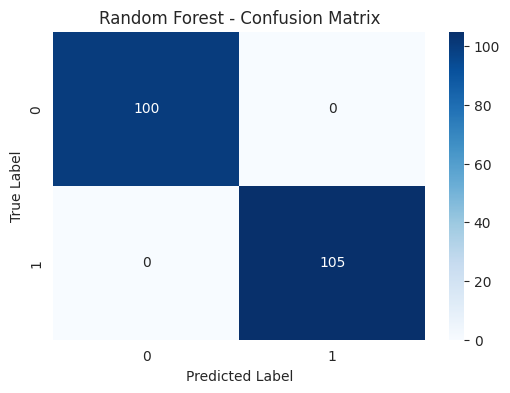

------------------------------
--- Training Support Vector Machine ---

--- Results for Support Vector Machine ---
Training Accuracy: 0.9512
Test Accuracy: 0.9463
Test ROC AUC: 0.9753
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       100
           1       0.94      0.96      0.95       105

    accuracy                           0.95       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205

Test Confusion Matrix:
 [[ 93   7]
 [  4 101]]


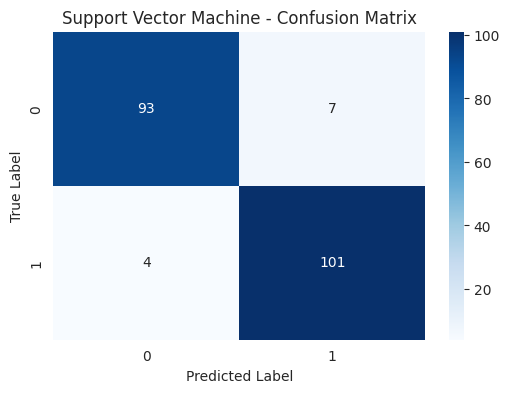

------------------------------


In [8]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42) # probability=True for ROC AUC
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"--- Training {name} ---")
    # Train the model
    model.fit(X_train_processed, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_processed)
    y_pred_test = model.predict(X_test_processed)
    y_prob_test = model.predict_proba(X_test_processed)[:, 1] # Probabilities for ROC AUC

    # Evaluate the model
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_prob_test)

    # Store results
    results[name] = {
        "model": model,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "classification_report": report_test,
        "confusion_matrix": cm_test,
        "roc_auc": roc_auc,
        "y_pred": y_pred_test,
        "y_prob": y_prob_test
    }

    # Print results
    print(f"\n--- Results for {name} ---")
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print("Test Classification Report:\n", report_test)
    print("Test Confusion Matrix:\n", cm_test)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("-" * 30)

4. Compare Models and Conclude


--- Model Comparison ---
                    Model  Test Accuracy  Test ROC AUC
1           Random Forest       1.000000      1.000000
2  Support Vector Machine       0.946341      0.975333
0     Logistic Regression       0.873171      0.943524


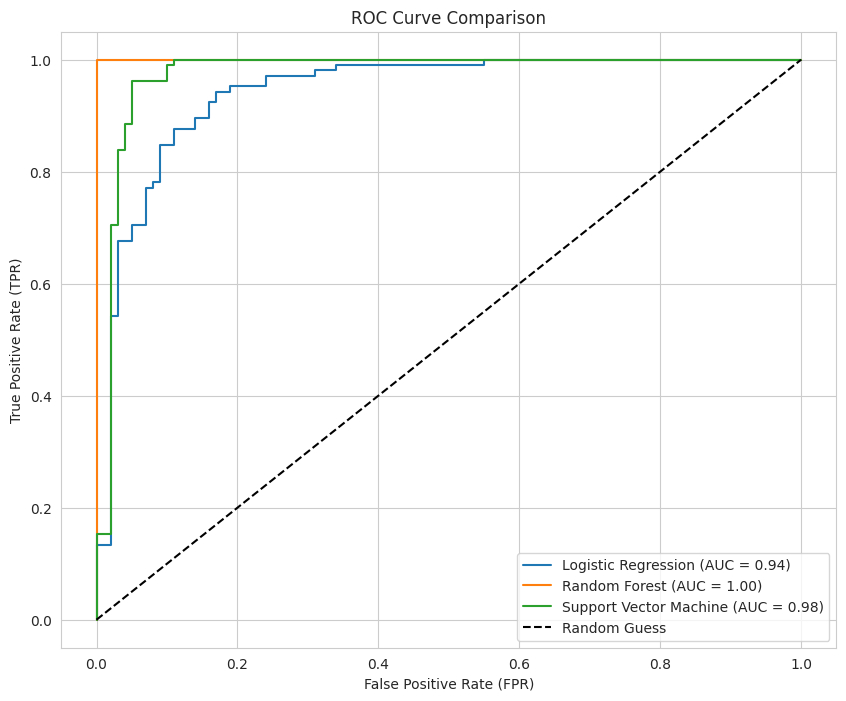

In [9]:
# Display comparison summary
print("\n--- Model Comparison ---")
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        "Model": name,
        "Test Accuracy": result['accuracy_test'],
        "Test ROC AUC": result['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.sort_values(by='Test ROC AUC', ascending=False))

# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Dashed line for random guess
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()